In [1]:
# The idea is to do a simple linear model of non-linear interactions between basic statistics. We will motivate these
# interactions based on some intuitions. For example, (mean / std) should influence the forecasting ability 
# different statistics, i.e. look at (mean / std) * mean. However, we do this for windows.

# A better basis is based on using r_i = (mean_window_i / mean_all) or r_i = (mean_window_i / (epsilon + mean_all)).
# Normally, one could estimate using the average of the mean_window_i (or some weighted average). However, when 
# r_i is large, one wants to replace mean_window_i by mean_all. So we are lead to trying basis functions such as
# f_i = exp(-K_i * r_i) * mean_window_i + (1 - exp(-K_i * r_i)) * mean_all, where K_i is a constant parameter that
# can be adjusted. First try finding optimal K_i that increase linear correlation between Y_mean and f_i.
# Also can try using logit functions of r_i or some other functions that is suggestive of a neural network.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

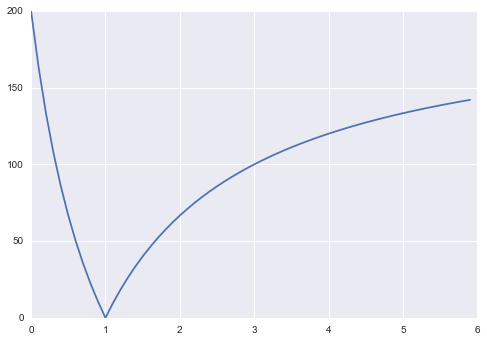

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
futureT = 64

X_all = all_df.drop('Page', axis = 1).values[:, :-futureT]
Y_all = all_df.drop('Page', axis = 1).values[:, -futureT:]

In [7]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 486) 	X_valid.shape =  (32074, 486) 	X_test.shape =  (47871, 486)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [48]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def window_features(X_window, epsilon = 1e-4):
    nSamples, nTime = X_window.shape
    means = np.mean(X_window, axis = 1, keepdims = True)
    features = means.copy()
    stds = np.std(X_window, axis = 1, keepdims = True)
    mult = means / (stds + epsilon)
    features = np.hstack((features, mult))
    
    Lrange = np.arange(nTime) - (nTime - 1) / 2
    Ldot = np.dot(X_window, Lrange).reshape(-1,1)
    features = np.hstack((features, Ldot))
    return features
    
def window_names():
    return ['means', 'mult', 'Ldot']

def multi_names(nWindows):
    multiNames = []
    
    for i in range(nWindows):
        for name in window_names():
            multiNames.append(name + str(i+1))
    return multiNames

def multiWindow_features(X, nWindows = 2, windowSize = 64):
    nSamples, nTime = X.shape
    newFeatures = np.empty((nSamples, 0))
    for i in range(nWindows):
        X_window = X[:, -(i+1) * windowSize - 1: -i * windowSize - 1]
        newCols = window_features(X_window)
        newFeatures = np.hstack((newFeatures, newCols))
    return newFeatures

In [21]:
# Let's look at shape of features.

multiWindowCols = all_features(X_train)
print('multiWindowCols.shape = ', multiWindowCols.shape)

multiWindowCols.shape =  (65118, 6)


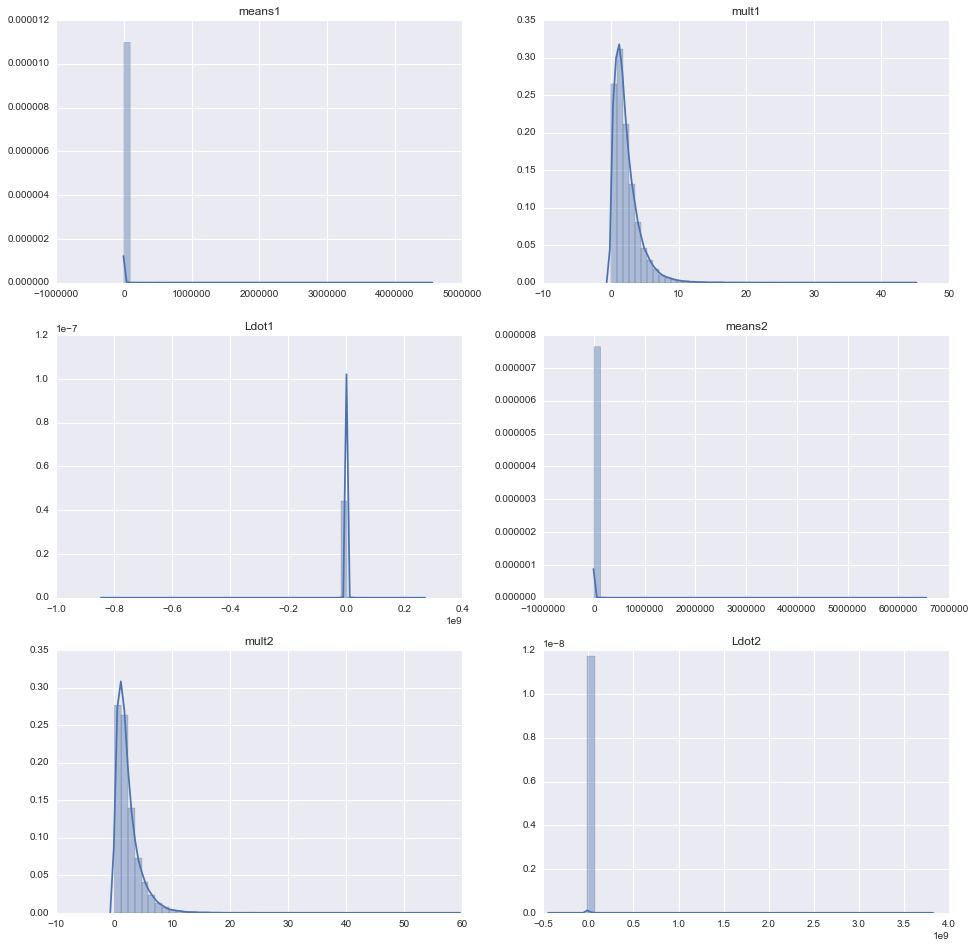

In [45]:
# Get histogram of feature values.

nSamples, nFeatures = multiWindowCols.shape

plt.figure(figsize = (16, 16))
names = window_names()
for i in range(nFeatures):
    plt.subplot('32' + str(i+1))
    nameI = i % 3
    plotI = int(i / 3)
    plt.title(names[nameI] + str(plotI + 1))
    sns.distplot(multiWindowCols[:,i])
    
plt.show()

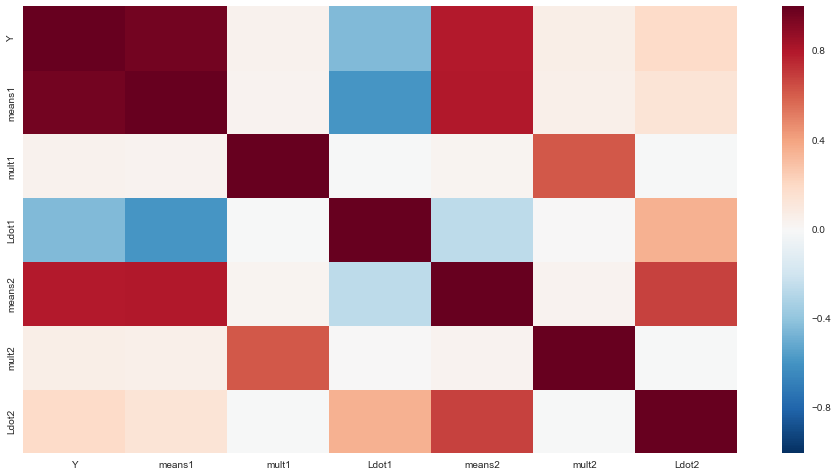

In [61]:
# Let's check linear correlations between mean Y and features we have extracted.

Y_mean = np.mean(Y_train, axis = 1, keepdims = True)

corr_vars = np.hstack((Y_mean, multiWindowCols)).T
corr_names = ['Y'] + multi_names(2)
corr_matrix = np.corrcoef(corr_vars)

plt.figure(figsize = (16, 8))
sns.heatmap(corr_matrix, xticklabels = corr_names, yticklabels = corr_names)
plt.show()

In [ ]:
# Now let's check the linear correlation of interactions.

corr_vars = np.hstack((Y_mean, multiWindowCols[:, 0, 2, 3, 5]))
corr_matrix = np.corrcoef(corr_vars.T)
names = 